In [2]:
from collections import namedtuple
from multiprocessing import Pool
import random
import copy
from sklearn import metrics
import keras
from keras import models, layers
from collections import defaultdict
import numpy as np 
import pandas as pd
import pickle
import datetime
import scipy.stats
import matplotlib.pyplot as plt
from time import sleep

Using TensorFlow backend.


#### 0. Вспомогательная функции и классы

In [4]:
def log_progress(sequence, every=1):
        from ipywidgets import IntProgress
        from IPython.display import display

        progress = IntProgress(min=0, max=len(sequence), value=0)
        display(progress)


        for index, record in enumerate(sequence):
            if index % every == 0:
                if index == len(sequence):
                     progress.value = len(sequence)
                progress.value = index
            yield record

In [ ]:
for i in log_progress(range(400)):
    sleep(0.01)

In [30]:
def mape(y_true, y_pred):
    "Функция вычисления mape"
    import warnings
    warnings.simplefilter('ignore')
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    result = abs(y_true-y_pred)/y_true
    result[np.where(np.isnan(result)| np.isinf(result))] = 0 
    return np.mean(result)*100

In [55]:
def mae(y_true, y_pred):
    "Функция вычисления mape"
    import warnings
    warnings.simplefilter('ignore')
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    result = abs(y_true-y_pred)
    return np.mean(result)

In [5]:
class Normalizer:
    def __init__(self, data: pd.DataFrame = None):
        if data:
            self.mean = data.mean(axis=0)
            self.std = data.std(axis=0)
            
    def fit(self, data):
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        
        self.std.loc[self.std == 0] = 1 
        
    def transform(self, data): 
        if hasattr(self, 'mean'):
            data  -= self.mean 
            data /= self.std
            return data
        else:
            raise AttributeError('Сначала вызовите метод fit(data: pd.DataFrame)')
            
    def reverse_transform(self, data):
        data = data * self.std
        data = data + self.mean
        return data 
          
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

####  1. Определение структур данных

In [6]:
# Для моделирования используются две выборки: train и test
# start - отмечает начало train'a
# test - отмечает начало test'a
Boundaries = namedtuple('Boundaries',['start', 'test'])

start = datetime.datetime(2017, 2, 20, 0, 0)
test = datetime.datetime(2018, 4, 2, 0, 0)

bnd = Boundaries(start, test)

In [7]:
# namedtuple - кортеж с именоваными полями
bnd.start

datetime.datetime(2017, 2, 20, 0, 0)

In [8]:
class VSP:
    "Структура данных для хранения информации о ВСП" 
    
    def __init__(self, name):
        self.name = name
        # Значения временного ряда
        self.y_train = self.y_test = None 
        # Признаковое описание ряда (экзогенные факторы)
        self.x_train =  self.x_test = None 

In [ ]:
help(VSP)

####  2. Преобразование данных из формата хранения

In [ ]:
# файл Николая с экзогенными признаками
td_list = pickle.load(open('D:/td_list_all_ext_ext_f.pkl', 'rb')) 

In [ ]:
# преобразование данных из формата в которм их хранил Николай в мой формат VSP
data = list() # список из объектов типа VSP
for name, train, validation, test in td_list:
    vsp = VSP(name)
    
    # Значения временного ряда
    vsp.y_train = train.trg.append(validation.trg)
    vsp.y_test = test.trg

    # Признаковое описание ряда (экзогенные факторы)
    vsp.x_train = train.iloc[:,1:].append(validation.iloc[:,1:]) 
    vsp.x_test = test.iloc[:,1:]
    data.append(vsp)

#### 3. Фильтрация пустых рядов

In [ ]:
# очистка от пустых 
clear_data = [vsp for vsp in data 
             if sum(vsp.y_train != 0) > 70  and 
             sum(vsp.y_test != 0) > 20]

#### 4. Генерация дополнительных признаков

In [ ]:
td_list_series = pickle.load(open('D:/td_list_all_ext.pkl', 'rb'))

In [ ]:
add_data = list()
DATE_PATTERN = pd.Series(0, index=pd.to_datetime(range(762+89+31), unit= "D", origin=pd.Timestamp('2016-01-01')))
name_set = {vsp.name for vsp in clear_data}

for name, series in log_progress(td_list_series):
    if name in name_set:
        vsp = VSP(name)
        
        # Агрегация рядов по дням
        # 24*4 = 96 пятнадцатиминуток в одном дне
        vsp.y_all = pd.Series(data=series.trg,
                              index=series.index).rolling('1d', min_periods=1).sum()[95::96] 
        
        vsp.y_all.index = pd.to_datetime(vsp.y_all.index.date)

        # Заполнение недостающих дней нулями
        vsp.y_all = pd.Series(vsp.y_all)
        
        vsp.y_all, _ = vsp.y_all.align(DATE_PATTERN, join='right')
        vsp.y_all.fillna(0, inplace = True)
        
        # Значения временного ряда
        vsp.x_train = pd.DataFrame(index = vsp.y_all[bnd.start:bnd.test].index) 
        vsp.x_test = pd.DataFrame(index = vsp.y_all[bnd.test:].index) 

        for i in range(70,78):
            a = vsp.y_all.shift(i)
            vsp.x_train['trg_%d'%i] = a[bnd.start:bnd.test]
            vsp.x_test['trg_%d'%i] = a[bnd.test:]
            
        for i in [84, 91, 98]:
            a = vsp.y_all.shift(i)
            vsp.x_train['trg_%d'%i] = a[bnd.start:bnd.test]
            vsp.x_test['trg_%d'%i] = a[bnd.test:]

        # Ряд  первых производных 
        vsp.y_all_d = vsp.y_all - vsp.y_all.shift(1)
    
        # Ряд  вторых производных 
        vsp.y_all_dd = vsp.y_all_d - vsp.y_all_d.shift(1)

        # Производим признаки из производных 
        for i in range(1,15):
            a = vsp.y_all_d.shift(62+i)
            b = vsp.y_all_d.shift(52*7+i)
            vsp.x_train['diff_%d'%i] = a[:bnd.test]
            vsp.x_train['diff_year_%d'%i] = b[bnd.start:bnd.test]
            vsp.x_test['diff_%d'%i] = a[bnd.test:]
            vsp.x_test['diff_year_%d'%i] = b[bnd.test:]
        
        for i in range(22,37,7):
            a = vsp.y_all_d.shift(62+i)
            b = vsp.y_all_d.shift(52*7+i)
            vsp.x_train['diff_%d'%i] = a[:bnd.test]
            vsp.x_train['diff_year_%d'%i] = b[bnd.start:bnd.test]
            vsp.x_test['diff_%d'%i] = a[bnd.test:]
            vsp.x_test['diff_year_%d'%i] = b[bnd.test:]

        for i in range(1,15):
            vsp.x_test['double_diff_%d'%i] = vsp.y_all_dd.shift(62+i)[bnd.test:]
            vsp.x_test['double_diff__year_%d'%i] = vsp.y_all_dd.shift(52*7+i)[bnd.test:]
            vsp.x_train['double_diff_%d'%i] = vsp.y_all_dd.shift(62+i)[bnd.start:bnd.test]
            vsp.x_train['double_diff__year_%d'%i] = vsp.y_all_dd.shift(52*7+i)[bnd.start:bnd.test]
            
        for i in range(22,37,7):
            vsp.x_test['double_diff_%d'%i] = vsp.y_all_dd.shift(62+i)[bnd.test:]
            vsp.x_test['double_diff__year_%d'%i] = vsp.y_all_dd.shift(52*7+i)[bnd.test:]
            vsp.x_train['double_diff_%d'%i] = vsp.y_all_dd.shift(62+i)[bnd.start:bnd.test]
            vsp.x_train['double_diff__year_%d'%i] = vsp.y_all_dd.shift(52*7+i)[bnd.start:bnd.test]
            
        # Месяцы как флаги
        for i in range(1,13):
            vsp.x_test.loc[vsp.x_test.index.month == i, 'month_%d'%i] = 1
            vsp.x_test.loc[vsp.x_test.index.month != i, 'month_%d'%i] = 0
            vsp.x_train.loc[vsp.x_train.index.month == i, 'month_%d'%i] = 1
            vsp.x_train.loc[vsp.x_train.index.month != i, 'month_%d'%i] = 0

        add_data.append(vsp)

In [ ]:
pickle.dump(add_data, open('D:/td_list_add_features.pkl', 'wb'))

In [ ]:
add_data = pickle.load(open('D:/td_list_add_features.pkl', 'rb'))

#### 4. Присоединение  дополнительных признаков

In [ ]:
# В списке clear_data теперь хранятся vsp c дополнительными признаками
for vsp_a in clear_data: 
    for vsp_b in add_data: 
        if vsp_a.name == vsp_b.name:
            vsp_a.x_train = pd.concat([vsp_a.x_train,vsp_b.x_train.iloc[:-1,:]], axis=1)
            vsp_a.x_test = pd.concat([vsp_a.x_test,vsp_b.x_test.iloc[:-1,:]], axis=1)

In [ ]:
pickle.dump(clear_data, open('D:/clear_data.pkl', 'wb'))

In [9]:
clear_data = pickle.load(open('D:/clear_data.pkl', 'rb'))

#### 5. Формирование обучающей выборки 

In [10]:
X_train = pd.concat([vsp.x_train for vsp in clear_data]) 
Y_train = pd.concat([vsp.y_train for vsp in clear_data]) 
X_test = pd.concat([vsp.x_test for vsp in clear_data]) 
Y_test = pd.concat([vsp.y_test for vsp in clear_data]) 

In [11]:
normalizer = Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [12]:
X_test.fillna(0,inplace=True)
X_train.fillna(0,inplace=True)

In [13]:
pickle.dump((X_train, Y_train, X_test, Y_test), open('D:/train_test.pkl', 'wb'))

In [14]:
X_train, Y_train, X_test, Y_test = pickle.load(open('D:/train_test.pkl', 'rb'))

#### 6. Обучение нейросети

In [25]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape =(X_train.shape[1],)))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics = ['mae'])

In [26]:
history = model.fit(np.array(X_train), np.array(Y_train), epochs = 3, batch_size = 1024,
                        validation_data = (np.array(X_test), np.array(Y_test)))

Train on 2390528 samples, validate on 353280 samples
Epoch 1/3
2390528/2390528 [==============================] - 39s 16us/step - loss: 1763.1349 - mean_absolute_error: 24.7770 - val_loss: 812.8828 - val_mean_absolute_error: 16.7309
Epoch 2/3
2390528/2390528 [==============================] - 39s 16us/step - loss: 579.0387 - mean_absolute_error: 15.6670 - val_loss: 741.1106 - val_mean_absolute_error: 16.1211
Epoch 3/3
2390528/2390528 [==============================] - 39s 17us/step - loss: 558.4510 - mean_absolute_error: 15.6381 - val_loss: 745.2236 - val_mean_absolute_error: 15.9743


In [27]:
model.evaluate(np.array(X_test), np.array(Y_test))

353280/353280 [==============================] - 6s 18us/step


[745.22356913538943, 15.974345071613788]

#### 7.  Предсказания для тестовой выборки 

In [31]:
predictions = model.predict(np.array(X_test))
# Все предсказания меньше 1 зануляем
predictions = [i if i>1 else 0 for i in predictions.flatten()] 

In [33]:
# каждому vsp добавляем новый атрибут vsp.y_test_predict
finish = 0
for vsp in clear_data: 
    start, finish  = finish, finish + len(vsp.y_test)
    vsp.y_test_predict = pd.Series(data = predictions[start:finish],
                                   index = vsp.y_test.index)

In [36]:
test_mapes = pd.Series(mape(vsp.y_test,vsp.y_test_predict) for vsp in clear_data)

Медиана mape:  15.1625357679


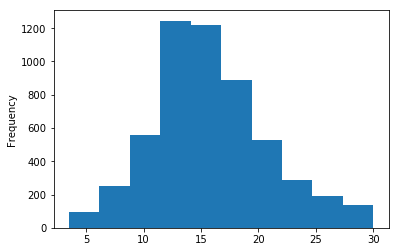

In [50]:
test_mapes[test_mapes<30].plot(kind='hist')
print('Медиана mape: ', np.median(test_mapes[test_mapes<30]))
plt.show()

In [56]:
test_maes = pd.Series(mae(vsp.y_test,vsp.y_test_predict) for vsp in clear_data)

Медиана mae:  12.1639063716


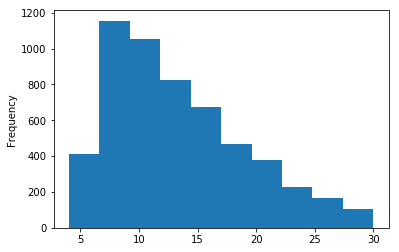

In [60]:
test_maes[test_maes<30].plot(kind='hist')
print('Медиана mae: ', np.median(test_maes[test_maes<30]))
plt.show()

#### 7.  Предсказания для обучающей выборки 

In [61]:
predictions = model.predict(np.array(X_train))
# Все предсказания меньше 1 зануляем
predictions = [i if i>1 else 0 for i in predictions.flatten()] 

In [62]:
# каждому vsp добавляем новый атрибут vsp.y_train_predict
finish = 0
for vsp in clear_data: 
    start, finish  = finish, finish + len(vsp.y_train)
    vsp.y_train_predict = pd.Series(data = predictions[start:finish],
                                   index = vsp.y_train.index)

In [63]:
train_mapes = pd.Series(mape(vsp.y_train, vsp.y_train_predict) for vsp in clear_data)

Медиана mape:  15.7802118781


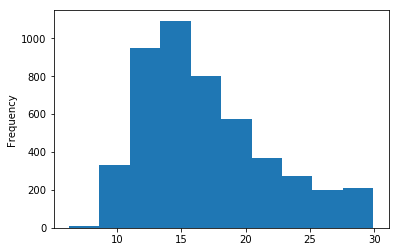

In [64]:
train_mapes[train_mapes<30].plot(kind='hist')
print('Медиана mape: ', np.median(train_mapes[train_mapes<30]))
plt.show()

In [65]:
train_maes = pd.Series(mae(vsp.y_train, vsp.y_train_predict) for vsp in clear_data)

Медиана mae:  10.0322627634


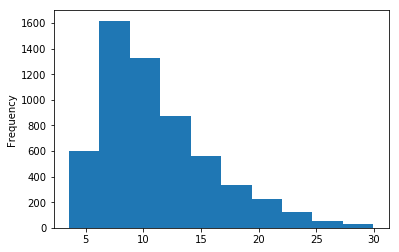

In [68]:
train_maes[train_maes<30].plot(kind='hist')
print('Медиана mae: ', np.median(train_maes[train_maes<30]))
plt.show()

#### 8.  Построение сводной таблицы результатов

In [174]:
def pivot_mape(data):
    'Внимание индекс месяца должен быть уникальным!!!'
    
    data["tochnost"] = abs(data.fact - data.predict)/data.fact
    data.loc[data.fact==0, "tochnost"] = 0 # заменим нулями
    data = data[data.fact!=0]
    # если в выборке есть одинаковые месяцы двух разных лет 2017 и 2018 они объединятся
    l = data.groupby([data.index.month, "VSP"])["tochnost"].mean().reset_index()
    l["group"] = l["tochnost"]//0.05
    l["group"] = l["group"].apply(lambda x: x if x < 6 else 6)

    # откорректируем словарь
    spr = {0: 5,
           1: 10,
           2: 15,
           3: 20,
           4: 25,
           5: 30, 
           6: 100}
    l["group"] = l["group"].map(spr)
    z = l.pivot_table(values="VSP", index="group", columns="date", aggfunc='count', fill_value = 0)
    z = z.cumsum()/z.sum()*100
    z = z.apply(lambda x: round(x)).astype(int)
    return z


In [180]:
# Подготовка данных под формат работы функции pivot
data_mp = pd.DataFrame()
for vsp in log_progress(clear_data,every=20):
    y_predict = vsp.y_train_predict[datetime.datetime(2017, 10, 1, 0, 0):].copy() 
    y_predict = pd.concat([y_predict,vsp.y_test_predict]) 
    vsp_df = pd.DataFrame(y_predict, index=y_predict.index, columns = ['predict'])
    vsp_df['VSP'] = vsp.name
    y_fact = vsp.y_train[datetime.datetime(2017, 10, 1, 0, 0):].copy() 
    y_fact = pd.concat([y_fact,vsp.y_test]) 
    vsp_df['fact'] = y_fact
    data_mp = pd.concat([data_mp,vsp_df],axis=0)

In [181]:
pivot_mape(data_mp)

date,1,2,3,4,5,10,11,12
group,,,,,,,,
5,0,0,0,0,0,0,0,0
10,1,2,2,0,1,2,3,4
15,20,27,26,11,16,28,31,34
20,50,57,56,41,47,57,62,62
25,68,74,74,66,70,73,79,77
30,79,83,83,79,83,82,86,86
100,100,100,100,100,100,100,100,100


In [184]:
def pivot_mae(data):
    data["tochnost"] = abs(data.fact - data.predict)
    data.loc[(data.fact==0), "tochnost"] = 0 # заменим нулями
    data = data[data.fact != 0]

    l = data.groupby([data.index.month, "VSP"])["tochnost"].mean().reset_index()
    l["group"] = l["tochnost"]//5
    l["group"] = l["group"].apply(lambda x: x if x < 6 else 6)

    # откорректируем словарь
    spr = {0: 5,
           1: 10,
           2: 15,
           3: 20,
           4: 25,
           5: 30, 
           6: 100}
    l["group"] = l["group"].map(spr)
    z = l.pivot_table(values="VSP", index="group", columns="date", aggfunc='count', fill_value = 0)
    z = z.cumsum()/z.sum()*100
    z = z.apply(lambda x: round(x)).astype(int)
    return z

In [185]:
pivot_mae(data_mp)

date,1,2,3,4,5,10,11,12
group,,,,,,,,
5,0,1,1,0,0,0,0,0
10,27,37,34,19,12,30,29,20
15,64,72,71,59,44,65,66,58
20,83,88,87,82,70,83,84,80
25,91,95,94,92,84,91,92,90
30,95,97,97,97,92,95,96,94
100,100,100,100,100,100,100,100,100


#### 9.  Старый способ построения сводной таблицы

In [72]:
def add_mape(vsp):
    'mae ВКЛЮЧАЯ нулевые значения'
    import warnings
    warnings.simplefilter('ignore')
    vsp.mape = pd.Series()
    for year, month in [(2017,10),(2017,11),(2017,12),(2018,1),(2018,2),(2018,3)]:
        y_true = np.array(vsp.y_train[(vsp.y_train.index.month == month) & (vsp.y_train.index.year == year)])
        y_pred = np.array(vsp.y_train_predict[(vsp.y_train.index.month == month) & (vsp.y_train.index.year == year)])
        # у vsp появляется новый атрибут 
        vsp.mape.at[month] = mape(y_true,y_pred)

In [132]:
def add_mape(vsp):
    'mape ИСКЛЮЧАЯ нулевые значения'
    import warnings
    warnings.simplefilter('ignore')
    vsp.mape = pd.Series()
    for year, month in [(2017,10),(2017,11),(2017,12),(2018,1),(2018,2),(2018,3)]:
        y_true = np.array(vsp.y_train[(vsp.y_train.index.month == month) & (vsp.y_train.index.year == year)])
        y_pred = np.array(vsp.y_train_predict[(vsp.y_train.index.month == month) & (vsp.y_train.index.year == year)])
        # у vsp появляется новый атрибут 
        vsp.mape.at[month] = mape(y_true[y_true != 0],y_pred[y_true != 0])

In [135]:
def pivot_train(vsp_list):
    for vsp in vsp_list: 
        add_mape(vsp)
    
    result = pd.DataFrame(0, index=[5,10,15,20,25,30], columns=[10,11,12,1,2,3])
    for month in [10,11,12,1,2,3]:
        for vsp in vsp_list:
            try:
                if vsp.mape.at[month] < 5 : result.at[5,month]+=1
                if vsp.mape.at[month] < 10 : result.at[10,month]+=1
                if vsp.mape.at[month] < 15 : result.at[15,month]+=1
                if vsp.mape.at[month] < 20 : result.at[20,month]+=1
                if vsp.mape.at[month] < 25 : result.at[25,month]+=1
                if vsp.mape.at[month] < 30 : result.at[30,month]+=1   
            except KeyError:
                print(vsp.name)
    result = result/len(vsp_list)*100
    
    return result.apply(lambda x: round(x)).astype(int)

In [136]:
# Результаты аналогичны предыдущему способу
pivot_train(clear_data)

,10,11,12,1,2,3
5,0,0,0,0,0,0
10,2,3,4,1,2,2
15,28,31,34,20,27,26
20,57,62,62,50,57,56
25,73,79,77,68,74,73
30,81,86,85,79,83,83
